In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [23]:
zip_path = Path("numbers_capture.zip")
extract_path = Path("data")
model_path = Path("model.tflite")

In [24]:
if not extract_path.exists():
    print(f"Extracting {zip_path} into {extract_path}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Done")
else:
    print(f"{extract_path} already exists, skipping.")


def load_images_from_folder(base_folder: Path, num_per_class=20):
    images = []
    labels = []
    for class_path in sorted(base_folder.iterdir()):
        if class_path.is_dir():
            image_files = sorted(class_path.glob("*.png"))[:num_per_class]
            for image_path in image_files:
                with Image.open(image_path).convert("L") as img:
                    images.append(np.array(img))
                    labels.append(int(class_path.name))
    return np.array(images), np.array(labels)

test_images, test_labels = load_images_from_folder(extract_path, num_per_class=20)

print(f"Loaded {len(test_images)} images.")
print(f"Image data type: {test_images.dtype}")

data already exists, skipping.
Loaded 200 images.
Image data type: uint8


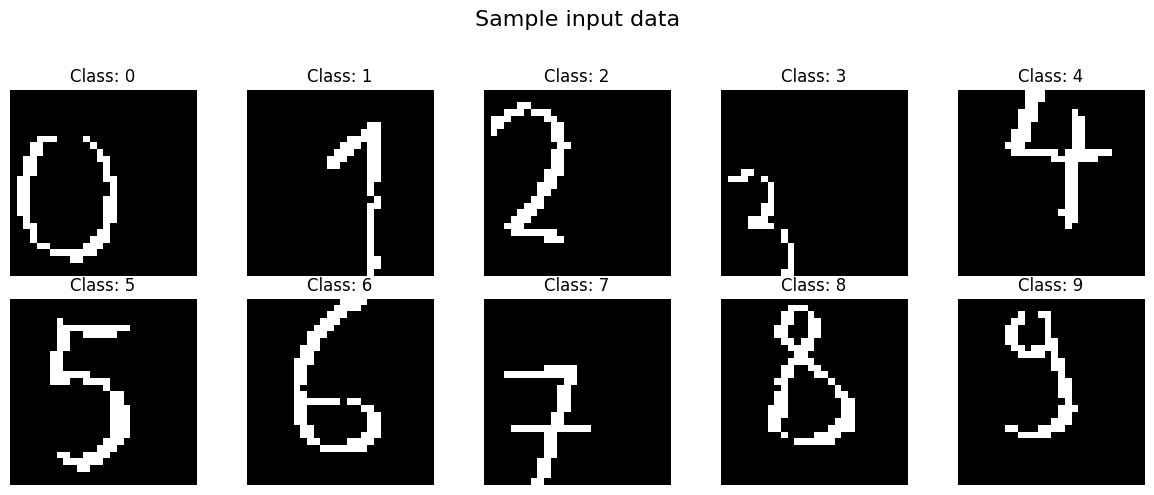

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    idx = np.where(test_labels == i)[0][0]

    ax = axes[i]
    ax.imshow(test_images[idx], cmap="gray")
    ax.set_title(f"Class: {i}")
    ax.axis("off")

plt.suptitle("Sample input data", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
interpreter = tf.lite.Interpreter(model_path=str(model_path))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print("--- Model input details ---")
print(f"  Shape: {input_details['shape']}")
print(f"  Input data type: {input_details['dtype']}")

print("--- Model output details ---")
print(f"  Shape: {output_details['shape']}")
print(f"  Output data type: {output_details['dtype']}")

--- Model input details ---
  Shape: [ 1 28 28  1]
  Input data type: <class 'numpy.uint8'>
--- Model output details ---
  Shape: [ 1 10]
  Output data type: <class 'numpy.uint8'>


In [27]:
predictions = []
input_dtype = input_details["dtype"]

for img in test_images:
    img_reshaped = img.reshape(1, 28, 28, 1)

    input_data = img_reshaped.astype(input_dtype)

    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details["index"])[0]

    predicted_label = np.argmax(output_data)
    predictions.append(predicted_label)

predictions_array = np.array(predictions)

print(f"Sample value: {test_labels[:10]}")
print(f"Sample prediction: {predictions_array[:10]}")

Sample value: [0 0 0 0 0 0 0 0 0 0]
Sample prediction: [0 0 0 0 0 0 0 0 0 0]


In [28]:
overall_accuracy = accuracy_score(test_labels, predictions_array)
print(f"Average accuracy: {overall_accuracy:.2%}")

print("Class accuracy:")
for i in range(10):
    class_indices = np.where(test_labels == i)[0]
    if len(class_indices) == 0:
        continue

    class_preds = predictions_array[class_indices]
    class_true = test_labels[class_indices]

    class_accuracy = accuracy_score(class_true, class_preds)
    print(f"  Class '{i}': {class_accuracy:.2%}")

Average accuracy: 99.50%
Class accuracy:
  Class '0': 100.00%
  Class '1': 100.00%
  Class '2': 100.00%
  Class '3': 100.00%
  Class '4': 100.00%
  Class '5': 100.00%
  Class '6': 100.00%
  Class '7': 100.00%
  Class '8': 95.00%
  Class '9': 100.00%


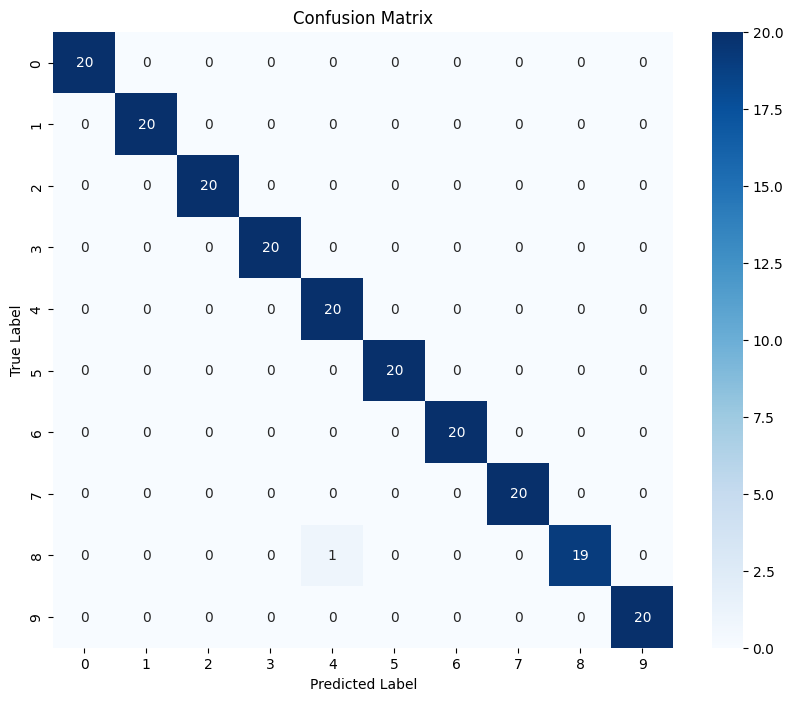

In [29]:
cm = confusion_matrix(test_labels, predictions_array)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10),
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()